In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [3]:
df = pd.read_csv("../csv/feedback-v2.csv")
df.columns = df.columns.str.strip()

motiv_scale = {
    "Desmotivado(a)": 1,
    "Neutro(a)": 2,
    "Motivado(a)": 3,
    "Muito motivado(a)": 4
}

motiv_cols = ["Estudo de caso", "Survey", 
              "Revisão Sistemática da Literatura (RSL)", 
              "Análise Estatística de Experimentos", 
              "Análise Qualitativa"]

contrib_scale = {
    "Discordo totalmente": 1,
    "Discordo": 2,
    "Neutro": 3,
    "Concordo": 4,
    "Concordo totalmente": 5
}

colunas = [
    'Estudo de caso',
    'Survey',
    'Revisão Sistemática da Literatura (RSL)',
    'Análise Estatística de Experimentos',
    'Análise Qualitativa',
    'Percepção Contribuição'
]

In [4]:
for col in motiv_cols:
    df[col] = df[col].map(motiv_scale)

df["Percepção Contribuição"] = df["Você acredita que a disciplina vai contribuir para sua formação?"] \
    .map(contrib_scale) \
    .fillna(3)

In [5]:
df = df[colunas]

# Verifica se há valores nulos
print(df.isna().sum())

correlacao = df.corr('spearman')

Estudo de caso                             0
Survey                                     0
Revisão Sistemática da Literatura (RSL)    0
Análise Estatística de Experimentos        0
Análise Qualitativa                        0
Percepção Contribuição                     0
dtype: int64


In [6]:
print(correlacao)

                                         Estudo de caso    Survey  \
Estudo de caso                                 1.000000  0.482504   
Survey                                         0.482504  1.000000   
Revisão Sistemática da Literatura (RSL)        0.075563  0.043284   
Análise Estatística de Experimentos            0.331418  0.138502   
Análise Qualitativa                            0.459640  0.530777   
Percepção Contribuição                         0.632785  0.467707   

                                         Revisão Sistemática da Literatura (RSL)  \
Estudo de caso                                                          0.075563   
Survey                                                                  0.043284   
Revisão Sistemática da Literatura (RSL)                                 1.000000   
Análise Estatística de Experimentos                                     0.511640   
Análise Qualitativa                                                     0.129911   
Percepção Co

## Comparação entre Motivação e Tipo de Estudo Realizado

Agora vamos comparar os resultados de motivação com o tipo de estudo que cada aluno apresentou durante a disciplina.


In [7]:
# Carrega os dados de notas para obter o tipo de estudo apresentado
df_notas = pd.read_csv("../csv/notas.csv")
df_notas.columns = df_notas.columns.str.strip()

# Carrega novamente o feedback completo para ter a matrícula
df_feedback_completo = pd.read_csv("../csv/feedback-v2.csv")
df_feedback_completo.columns = df_feedback_completo.columns.str.strip()

# Prepara os dados de motivação novamente
for col in motiv_cols:
    df_feedback_completo[col] = df_feedback_completo[col].map(motiv_scale)

df_feedback_completo["Percepção Contribuição"] = df_feedback_completo["Você acredita que a disciplina vai contribuir para sua formação?"] \
    .map(contrib_scale) \
    .fillna(3)

# Faz o merge usando a matrícula
df_comparacao = df_feedback_completo.merge(
    df_notas[['Matrícula', 'APRESENTAÇÃO']], 
    left_on='Qual sua matrícula?', 
    right_on='Matrícula', 
    how='inner'
)

print(f"Total de alunos com dados completos: {len(df_comparacao)}")
print(f"\nTipos de apresentação encontrados:")
print(df_comparacao['APRESENTAÇÃO'].value_counts())


Total de alunos com dados completos: 21

Tipos de apresentação encontrados:
APRESENTAÇÃO
ED2        5
ED1        4
ED4        2
ED3        2
TP1+ED4    2
TP1        1
ED2+TP1    1
Name: count, dtype: int64


In [8]:
# Mapeia os tipos de apresentação para os tipos de estudos
# ED1, ED2, ED3, ED4 são Estudos Dirigidos (podem ser sobre diferentes tipos)
# TP1, TP2 são Trabalhos Práticos (geralmente Estudo de Caso)
# Vamos criar uma função para mapear

def mapear_tipo_estudo(apresentacao):
    """Mapeia o tipo de apresentação para o tipo de estudo principal"""
    if pd.isna(apresentacao) or apresentacao == '':
        return 'Não informado'
    
    apresentacao = str(apresentacao).upper()
    
    # Trabalhos Práticos geralmente são Estudos de Caso
    if 'TP1' in apresentacao or 'TP2' in apresentacao:
        return 'Estudo de caso'
    
    # Estudos Dirigidos podem ser sobre diferentes tipos
    # Vamos usar uma heurística baseada nos nomes mais comuns
    if 'ED1' in apresentacao:
        return 'ED1'
    elif 'ED2' in apresentacao:
        return 'ED2'
    elif 'ED3' in apresentacao:
        return 'ED3'
    elif 'ED4' in apresentacao:
        return 'ED4'
    else:
        return 'Outro'

df_comparacao['Tipo Estudo Apresentado'] = df_comparacao['APRESENTAÇÃO'].apply(mapear_tipo_estudo)

print("Distribuição dos tipos de estudo apresentados:")
print(df_comparacao['Tipo Estudo Apresentado'].value_counts())


Distribuição dos tipos de estudo apresentados:
Tipo Estudo Apresentado
ED2               5
Não informado     4
ED1               4
Estudo de caso    4
ED4               2
ED3               2
Name: count, dtype: int64


In [9]:
# Calcula a média de motivação para cada tipo de estudo apresentado
resultados_comparacao = []

for tipo_estudo in df_comparacao['Tipo Estudo Apresentado'].unique():
    subset = df_comparacao[df_comparacao['Tipo Estudo Apresentado'] == tipo_estudo]
    
    if len(subset) > 0:
        resultado = {
            'Tipo Estudo Apresentado': tipo_estudo,
            'N': len(subset),
            'Média Motivação - Estudo de caso': subset['Estudo de caso'].mean(),
            'Média Motivação - Survey': subset['Survey'].mean(),
            'Média Motivação - RSL': subset['Revisão Sistemática da Literatura (RSL)'].mean(),
            'Média Motivação - Análise Estatística': subset['Análise Estatística de Experimentos'].mean(),
            'Média Motivação - Análise Qualitativa': subset['Análise Qualitativa'].mean(),
            'Média Percepção Contribuição': subset['Percepção Contribuição'].mean()
        }
        resultados_comparacao.append(resultado)

df_resultados = pd.DataFrame(resultados_comparacao)
print(df_resultados.to_string(index=False))


Tipo Estudo Apresentado  N  Média Motivação - Estudo de caso  Média Motivação - Survey  Média Motivação - RSL  Média Motivação - Análise Estatística  Média Motivação - Análise Qualitativa  Média Percepção Contribuição
          Não informado  4                              3.50                      3.75                    2.5                                   3.50                                   3.25                          4.75
                    ED2  5                              3.00                      2.80                    2.8                                   3.40                                   3.00                          4.80
                    ED4  2                              2.50                      3.00                    3.0                                   3.00                                   3.50                          4.50
                    ED1  4                              3.75                      3.00                    2.0                   

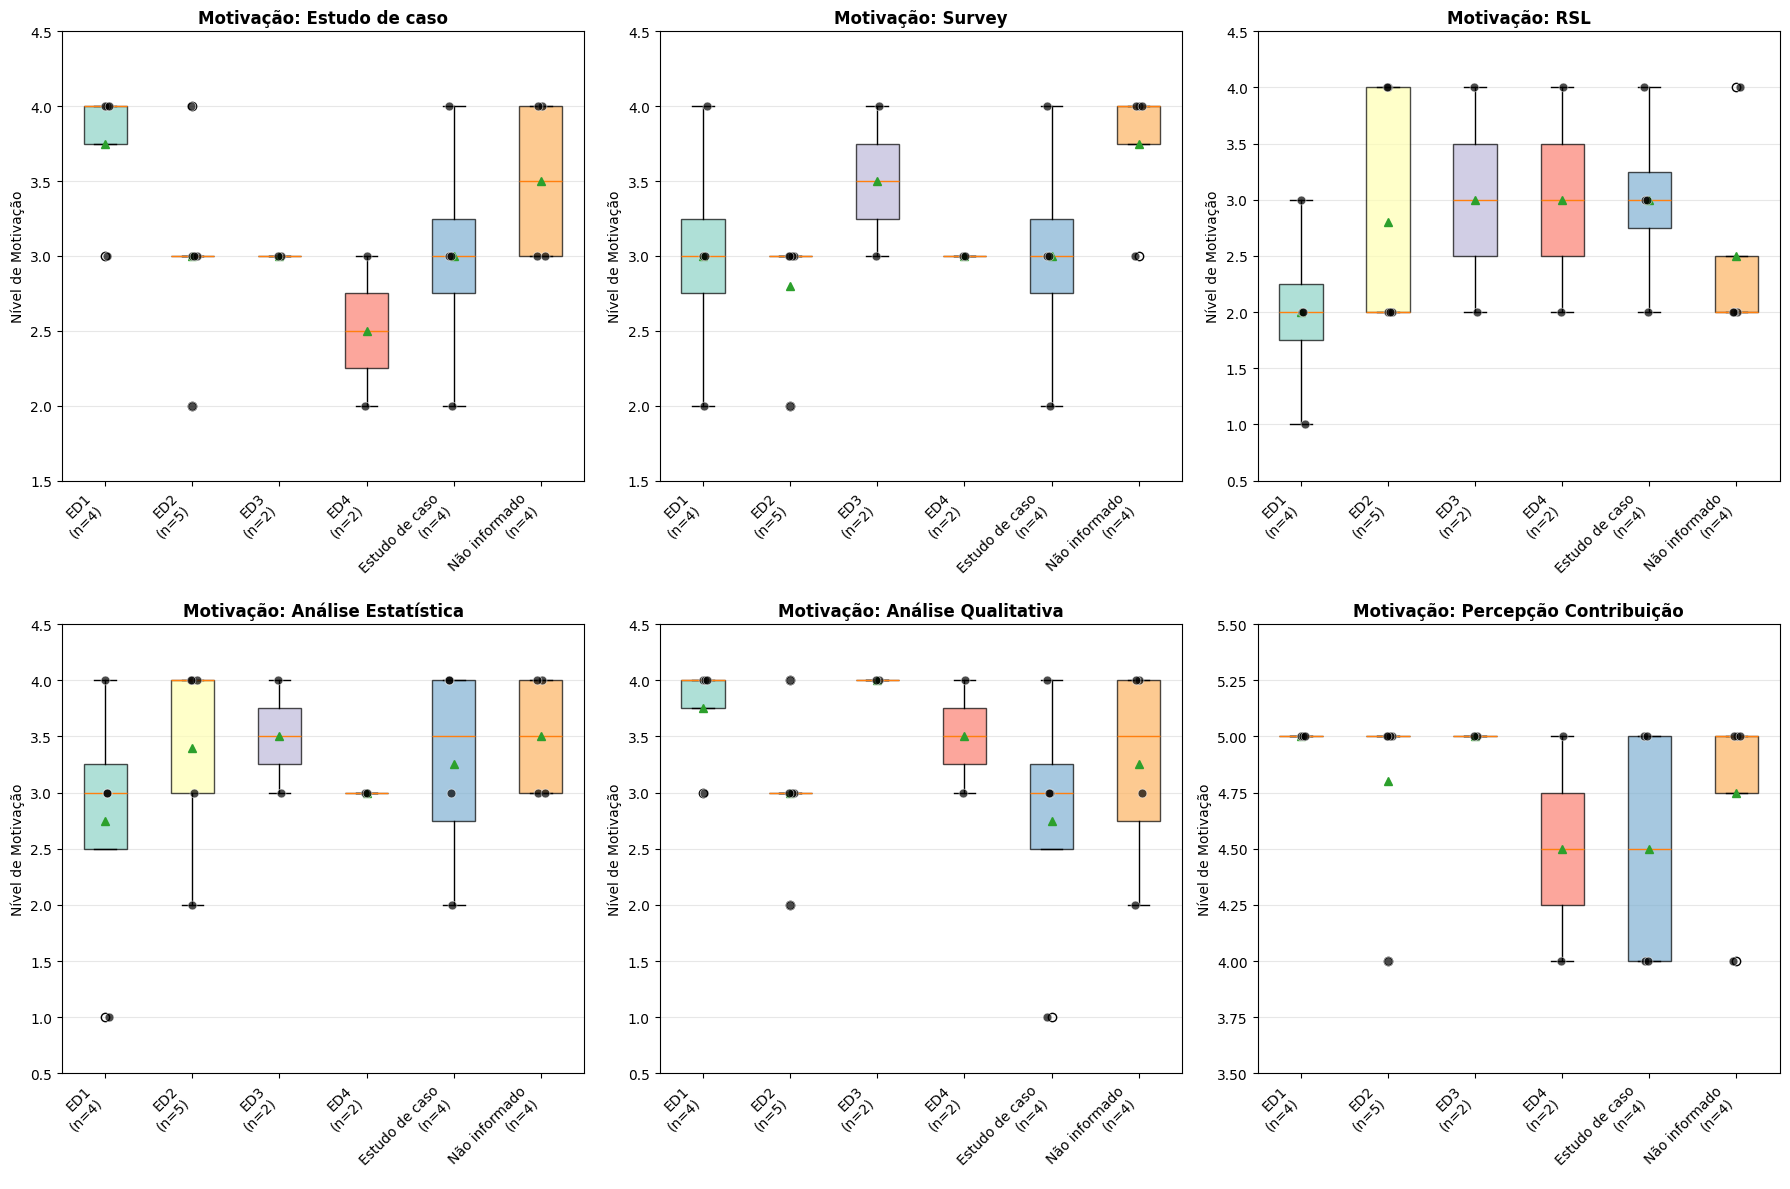

In [10]:
# Visualização: Comparação de motivação por tipo de estudo apresentado
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

tipos_motivacao = [
    ('Estudo de caso', 'Estudo de caso'),
    ('Survey', 'Survey'),
    ('Revisão Sistemática da Literatura (RSL)', 'RSL'),
    ('Análise Estatística de Experimentos', 'Análise Estatística'),
    ('Análise Qualitativa', 'Análise Qualitativa'),
    ('Percepção Contribuição', 'Percepção Contribuição')
]

for idx, (col_motiv, titulo) in enumerate(tipos_motivacao):
    dados_plot = []
    labels = []
    tamanhos_amostra = []
    
    for tipo_estudo in sorted(df_comparacao['Tipo Estudo Apresentado'].unique()):
        subset = df_comparacao[df_comparacao['Tipo Estudo Apresentado'] == tipo_estudo]
        if len(subset) > 0:
            valores = subset[col_motiv].dropna().values
            if len(valores) > 0:
                dados_plot.append(valores)
                labels.append(f"{tipo_estudo}\n(n={len(valores)})")
                tamanhos_amostra.append(len(valores))
    
    if dados_plot:
        # Cria o boxplot (sem tick_labels, que não é um parâmetro válido)
        bp = axes[idx].boxplot(dados_plot, patch_artist=True, showmeans=True, 
                              meanline=False, showfliers=True)
        
        # Define os labels corretamente usando set_xticklabels
        axes[idx].set_xticklabels(labels, rotation=45, ha='right')
        
        # Cores diferentes para cada box
        colors_box = plt.cm.Set3(range(len(bp['boxes'])))
        for patch, color in zip(bp['boxes'], colors_box):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        # Adiciona pontos individuais para amostras pequenas (n <= 5)
        # Isso ajuda a visualizar os dados quando há poucos valores
        np.random.seed(42)  # Para reprodutibilidade
        for i, (dados, n) in enumerate(zip(dados_plot, tamanhos_amostra)):
            if n <= 5:
                # Adiciona pontos individuais com pequeno jitter para evitar sobreposição
                x_pos = i + 1
                jitter = np.random.normal(0, 0.03, len(dados))
                axes[idx].scatter(x_pos + jitter, dados, color='black', 
                                 s=40, alpha=0.7, zorder=3, edgecolors='white', linewidths=0.5)
        
        # Ajusta os limites do eixo Y para melhor visualização
        all_values = np.concatenate(dados_plot)
        y_min = max(0, all_values.min() - 0.5)
        y_max = min(5.5, all_values.max() + 0.5)
        axes[idx].set_ylim(y_min, y_max)
        
        axes[idx].set_title(f'Motivação: {titulo}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Nível de Motivação', fontsize=10)
        axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [10]:
# Análise mais detalhada: Comparação entre quem apresentou TP (Trabalho Prático) vs ED (Estudo Dirigido)
df_comparacao['Categoria Apresentação'] = df_comparacao['APRESENTAÇÃO'].apply(
    lambda x: 'Trabalho Prático (TP)' if pd.notna(x) and ('TP1' in str(x).upper() or 'TP2' in str(x).upper()) 
    else ('Estudo Dirigido (ED)' if pd.notna(x) and any(f'ED{i}' in str(x).upper() for i in [1,2,3,4])
    else 'Outro/Não informado')
)

# Calcula estatísticas por categoria
categorias = df_comparacao['Categoria Apresentação'].unique()

print("=" * 80)
print("COMPARAÇÃO: Trabalho Prático vs Estudo Dirigido")
print("=" * 80)

for categoria in categorias:
    subset = df_comparacao[df_comparacao['Categoria Apresentação'] == categoria]
    if len(subset) > 0:
        print(f"\n{categoria} (n={len(subset)}):")
        print(f"  Média Motivação - Estudo de caso: {subset['Estudo de caso'].mean():.2f}")
        print(f"  Média Motivação - Survey: {subset['Survey'].mean():.2f}")
        print(f"  Média Motivação - RSL: {subset['Revisão Sistemática da Literatura (RSL)'].mean():.2f}")
        print(f"  Média Motivação - Análise Estatística: {subset['Análise Estatística de Experimentos'].mean():.2f}")
        print(f"  Média Motivação - Análise Qualitativa: {subset['Análise Qualitativa'].mean():.2f}")
        print(f"  Média Percepção Contribuição: {subset['Percepção Contribuição'].mean():.2f}")


COMPARAÇÃO: Trabalho Prático vs Estudo Dirigido

Outro/Não informado (n=4):
  Média Motivação - Estudo de caso: 3.50
  Média Motivação - Survey: 3.75
  Média Motivação - RSL: 2.50
  Média Motivação - Análise Estatística: 3.50
  Média Motivação - Análise Qualitativa: 3.25
  Média Percepção Contribuição: 4.75

Estudo Dirigido (ED) (n=13):
  Média Motivação - Estudo de caso: 3.15
  Média Motivação - Survey: 3.00
  Média Motivação - RSL: 2.62
  Média Motivação - Análise Estatística: 3.15
  Média Motivação - Análise Qualitativa: 3.46
  Média Percepção Contribuição: 4.85

Trabalho Prático (TP) (n=4):
  Média Motivação - Estudo de caso: 3.00
  Média Motivação - Survey: 3.00
  Média Motivação - RSL: 3.00
  Média Motivação - Análise Estatística: 3.25
  Média Motivação - Análise Qualitativa: 2.75
  Média Percepção Contribuição: 4.50


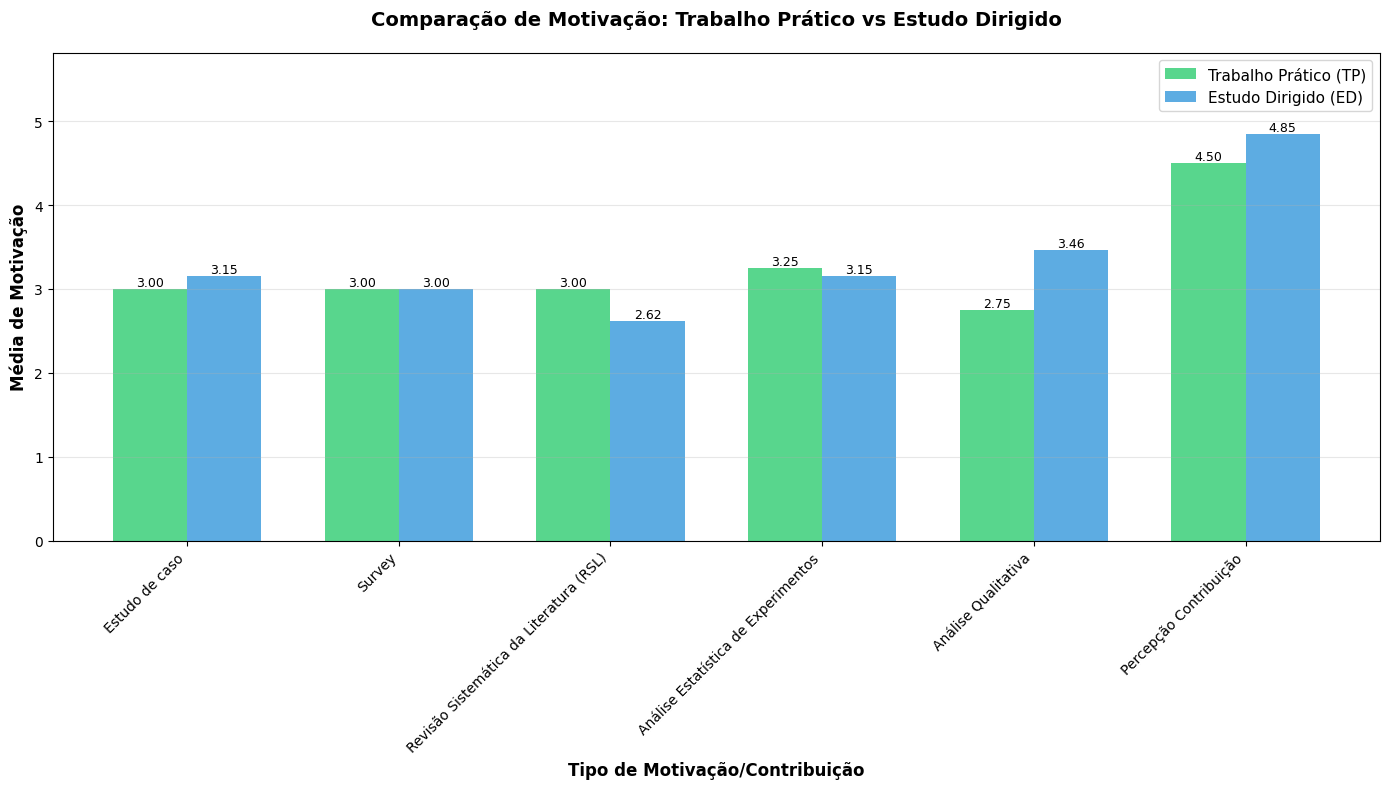

In [11]:
# Visualização comparativa: TP vs ED
fig, ax = plt.subplots(figsize=(14, 8))

# Prepara os dados
categorias_principais = ['Trabalho Prático (TP)', 'Estudo Dirigido (ED)']
tipos_motiv = ['Estudo de caso', 'Survey', 'Revisão Sistemática da Literatura (RSL)', 
               'Análise Estatística de Experimentos', 'Análise Qualitativa', 'Percepção Contribuição']

x = np.arange(len(tipos_motiv))
width = 0.35

medias_tp = []
medias_ed = []

for tipo in tipos_motiv:
    subset_tp = df_comparacao[df_comparacao['Categoria Apresentação'] == 'Trabalho Prático (TP)']
    subset_ed = df_comparacao[df_comparacao['Categoria Apresentação'] == 'Estudo Dirigido (ED)']
    
    medias_tp.append(subset_tp[tipo].mean() if len(subset_tp) > 0 else 0)
    medias_ed.append(subset_ed[tipo].mean() if len(subset_ed) > 0 else 0)

# Cria o gráfico de barras agrupadas
bars1 = ax.bar(x - width/2, medias_tp, width, label='Trabalho Prático (TP)', color='#2ecc71', alpha=0.8)
bars2 = ax.bar(x + width/2, medias_ed, width, label='Estudo Dirigido (ED)', color='#3498db', alpha=0.8)

# Adiciona valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Tipo de Motivação/Contribuição', fontsize=12, fontweight='bold')
ax.set_ylabel('Média de Motivação', fontsize=12, fontweight='bold')
ax.set_title('Comparação de Motivação: Trabalho Prático vs Estudo Dirigido', 
              fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(tipos_motiv, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(max(medias_tp), max(medias_ed)) * 1.2)

plt.tight_layout()
plt.show()


In [12]:
# Teste estatístico: Comparação entre TP e ED
from scipy import stats

print("=" * 80)
print("TESTES ESTATÍSTICOS: Trabalho Prático vs Estudo Dirigido")
print("=" * 80)

subset_tp = df_comparacao[df_comparacao['Categoria Apresentação'] == 'Trabalho Prático (TP)']
subset_ed = df_comparacao[df_comparacao['Categoria Apresentação'] == 'Estudo Dirigido (ED)']

if len(subset_tp) > 0 and len(subset_ed) > 0:
    for tipo in tipos_motiv:
        dados_tp = subset_tp[tipo].dropna()
        dados_ed = subset_ed[tipo].dropna()
        
        if len(dados_tp) > 0 and len(dados_ed) > 0:
            # Teste de normalidade (Shapiro-Wilk)
            stat_tp, p_tp = stats.shapiro(dados_tp)
            stat_ed, p_ed = stats.shapiro(dados_ed)
            
            # Se os dados são normais, usa t-test, senão usa Mann-Whitney
            if p_tp > 0.05 and p_ed > 0.05:
                stat, p_value = stats.ttest_ind(dados_tp, dados_ed)
                teste_usado = "t-test"
            else:
                stat, p_value = stats.mannwhitneyu(dados_tp, dados_ed, alternative='two-sided')
                teste_usado = "Mann-Whitney U"
            
            significativo = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            
            print(f"\n{tipo}:")
            print(f"  TP: média={dados_tp.mean():.2f}, n={len(dados_tp)}")
            print(f"  ED: média={dados_ed.mean():.2f}, n={len(dados_ed)}")
            print(f"  Teste: {teste_usado}, p={p_value:.4f} {significativo}")
else:
    print("\nDados insuficientes para comparação estatística.")


TESTES ESTATÍSTICOS: Trabalho Prático vs Estudo Dirigido

Estudo de caso:
  TP: média=3.00, n=4
  ED: média=3.15, n=13
  Teste: Mann-Whitney U, p=0.7551 ns

Survey:
  TP: média=3.00, n=4
  ED: média=3.00, n=13
  Teste: Mann-Whitney U, p=1.0000 ns

Revisão Sistemática da Literatura (RSL):
  TP: média=3.00, n=4
  ED: média=2.62, n=13
  Teste: Mann-Whitney U, p=0.4658 ns

Análise Estatística de Experimentos:
  TP: média=3.25, n=4
  ED: média=3.15, n=13
  Teste: Mann-Whitney U, p=0.9029 ns

Análise Qualitativa:
  TP: média=2.75, n=4
  ED: média=3.46, n=13
  Teste: Mann-Whitney U, p=0.2629 ns

Percepção Contribuição:
  TP: média=4.50, n=4
  ED: média=4.85, n=13
  Teste: Mann-Whitney U, p=0.1910 ns


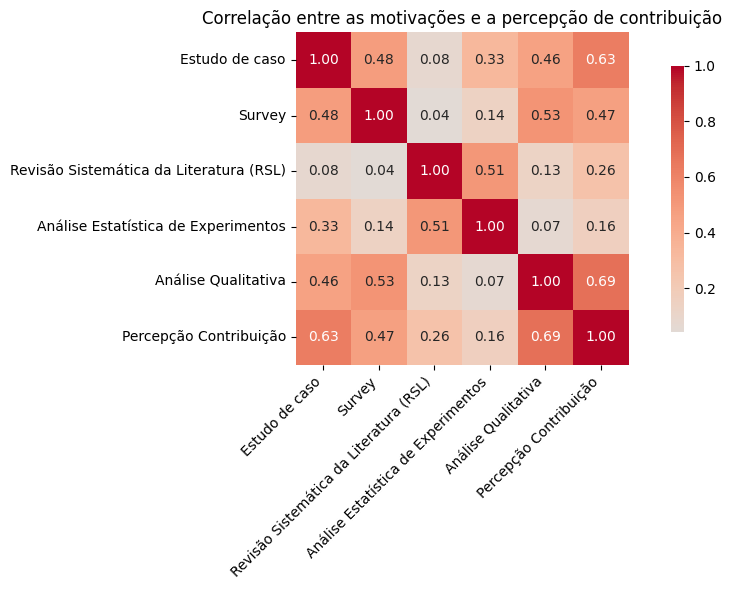

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    correlacao,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f",            # Duas casas decimais
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlação entre as motivações e a percepção de contribuição')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()